<a href="https://colab.research.google.com/github/HardikDahiya04/CSE_DA_2/blob/master/Alzheimers_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lukechugh_best_alzheimer_mri_dataset_99_accuracy_path = kagglehub.dataset_download('lukechugh/best-alzheimer-mri-dataset-99-accuracy')

print('Data source import complete.')


Data source import complete.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, callbacks
import os

In [5]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!mv "kaggle (1).json" kaggle.json


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d /content/alzheimer_data


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0


In [9]:
import os
print(os.listdir('/content/alzheimer_data'))
print(os.listdir('/content/alzheimer_data/Combined Dataset'))


['Combined Dataset']
['train', 'test']


In [10]:
import tensorflow as tf

img_size = 224
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/alzheimer_data/Combined Dataset/train',
    labels="inferred",
    color_mode='rgb',
    label_mode="categorical",
    image_size=(img_size, img_size),
    batch_size=32,
    shuffle=True
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/alzheimer_data/Combined Dataset/test',
    labels="inferred",
    color_mode='rgb',
    label_mode="categorical",
    image_size=(img_size, img_size),
    batch_size=32,
    shuffle=True
)


Found 10240 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


In [11]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess_pipeline(image, label):
    # Ensure 1-channel input (fixes mixed formats)
    if image.shape[-1] != 1:
        image = tf.image.rgb_to_grayscale(image)
    # Convert to RGB
    image = tf.image.grayscale_to_rgb(image)  # (224, 224, 1) → (224, 224, 3)
    # EfficientNet preprocessing
    image = preprocess_input(image)
    return image, label

# Apply to datasets
training_set = training_set.map(preprocess_pipeline)
validation_set = validation_set.map(preprocess_pipeline)


In [12]:
for images, labels in training_set.take(1):
    print("Final shape:", images.shape)  # Should be (batch_size, 224, 224, 3)


Final shape: (32, 224, 224, 3)


In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [13]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- Preprocess Function ---
def preprocess_pipeline(image, label):
    image = preprocess_input(image)  # EfficientNet-specific normalization
    return image, label

# Apply preprocessing
training_set = training_set.map(preprocess_pipeline)
validation_set = validation_set.map(preprocess_pipeline)


In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model

# Custom head
inputs = layers.Input(shape=(img_size, img_size, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs, name="Alzheimer_EfficientNet")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
from tensorflow.keras import callbacks

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,  # Reduced from 1e-3 to prevent overshooting
    decay_steps=1000,
    decay_rate=0.9
)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]


In [16]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=50,  # Reduced from 100 due to early stopping
    callbacks=callbacks
)


Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 58s 104ms/step - accuracy: 0.5134 - loss: 1.0913 - val_accuracy: 0.5582 - val_loss: 0.9738
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.6788 - loss: 0.7458 - val_accuracy: 0.5543 - val_loss: 0.9268
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.7086 - loss: 0.6771 - val_accuracy: 0.5661 - val_loss: 0.9026
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.7271 - loss: 0.6273 - val_accuracy: 0.5770 - val_loss: 0.8855
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.7451 - loss: 0.5898 - val_accuracy: 0.5950 - val_loss: 0.8625
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.7541 - loss: 0.5666 - val_accuracy: 0.5950 - val_loss: 0.8494
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.7637 - loss: 0.5417 - val_accuracy: 0.5942 - val_loss: 0.8416
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.7627 - loss: 0.5380 -

In [17]:
model.save("alzheimers_efficientnet_model.h5")


In [18]:
model.save("alzheimers_efficientnet_model.keras")


In [19]:
from google.colab import files
files.download("alzheimers_efficientnet_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

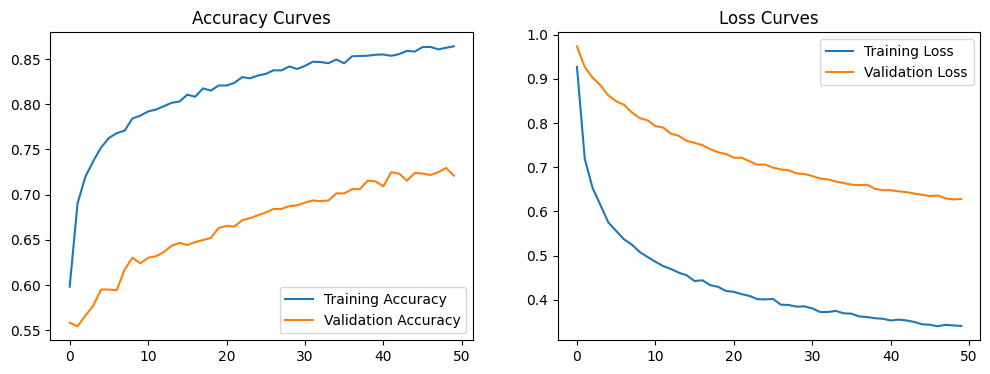

320/320 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8993 - loss: 0.2845
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7572 - loss: 0.6018
Final Training Accuracy: 90.23%
Final Validation Accuracy: 72.95%


In [21]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Evaluate
train_loss, train_acc = model.evaluate(training_set)
val_loss, val_acc = model.evaluate(validation_set)
print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")


Found 10240 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


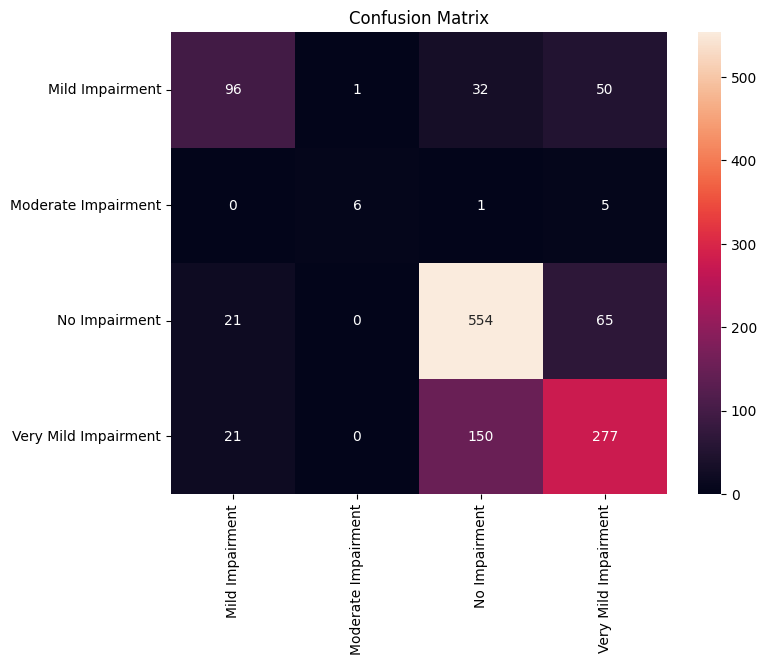

                      precision    recall  f1-score   support

     Mild Impairment       0.70      0.54      0.61       179
 Moderate Impairment       0.86      0.50      0.63        12
       No Impairment       0.75      0.87      0.80       640
Very Mild Impairment       0.70      0.62      0.66       448

            accuracy                           0.73      1279
           macro avg       0.75      0.63      0.67      1279
        weighted avg       0.73      0.73      0.72      1279



In [25]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load datasets
img_size = 224
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/alzheimer_data/Combined Dataset/train',
    labels="inferred",
    color_mode='rgb',
    label_mode="categorical",
    image_size=(img_size, img_size),
    batch_size=32,
    shuffle=True
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/alzheimer_data/Combined Dataset/test',
    labels="inferred",
    color_mode='rgb',
    label_mode="categorical",
    image_size=(img_size, img_size),
    batch_size=32,
    shuffle=True
)

# 2. Save class names **immediately after loading**
class_names = validation_set.class_names

# 3. Preprocessing (if needed)
from tensorflow.keras.applications.efficientnet import preprocess_input
def preprocess_pipeline(image, label):
    image = preprocess_input(image)
    return image, label

training_set = training_set.map(preprocess_pipeline)
validation_set = validation_set.map(preprocess_pipeline)

# 4. Use class_names in your evaluation code
y_true = []
y_pred = []

for images, labels in validation_set:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 5. Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


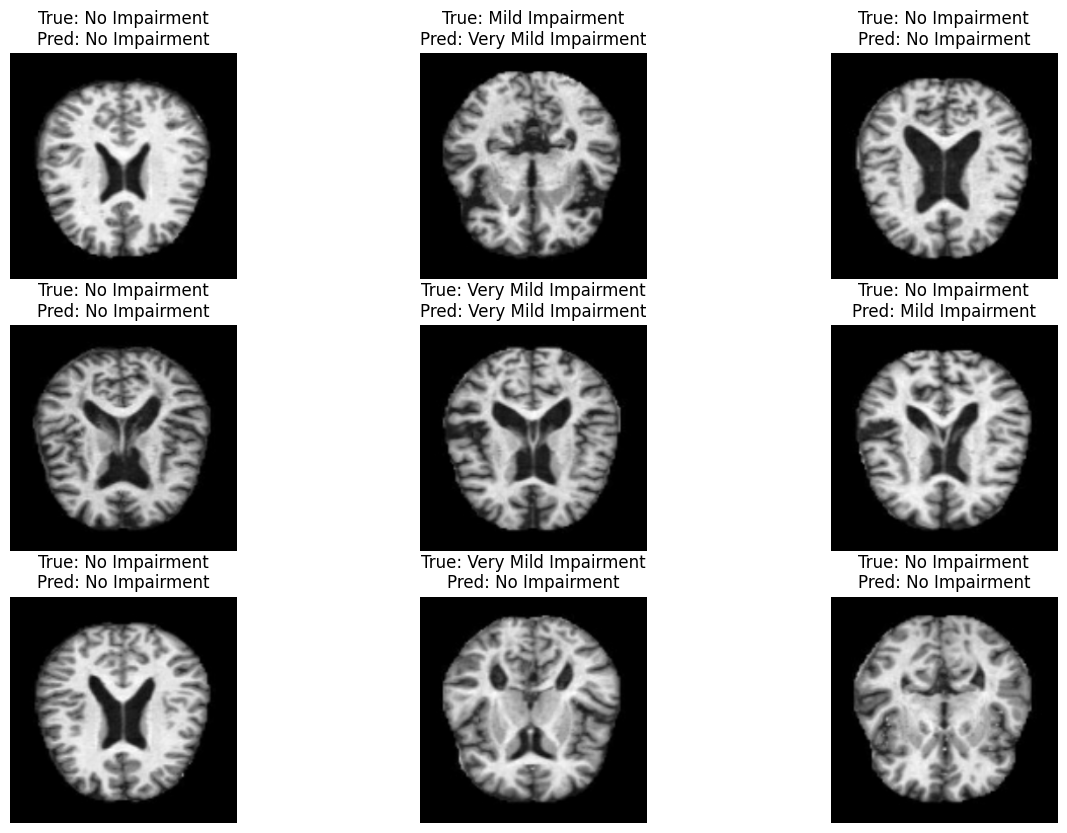

In [27]:
# Visualize predictions
for images, labels in validation_set.take(1):
    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Use the saved class_names variable (not validation_set.class_names)
        pred_label = class_names[np.argmax(model.predict(images[i:i+1], verbose=0))]
        true_label = class_names[np.argmax(labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()


In [28]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model("alzheimers_efficientnet_model.keras")

# Continue training
history2 = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=10,  # or more
    callbacks=callbacks  # optional
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 9 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


320/320 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.7097 - loss: 0.8302 - val_accuracy: 0.6013 - val_loss: 0.8014
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7474 - loss: 0.5705 - val_accuracy: 0.6122 - val_loss: 0.8027
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7536 - loss: 0.5513 - val_accuracy: 0.6192 - val_loss: 0.8572
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.7641 - loss: 0.5260 - val_accuracy: 0.5864 - val_loss: 0.9027
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.7786 - loss: 0.5150 - val_accuracy: 0.5598 - val_loss: 0.9276
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7795 - loss: 0.5082 - val_accuracy: 0.6458 - val_loss: 0.7505
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7873 - loss: 0.4919 - val_accuracy: 0.6325 - val_loss: 0.7815
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.7932 - loss: 0.4864 - val_accurac

In [29]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define paths in Google Drive
CHECKPOINT_PATH = '/content/drive/MyDrive/Alzheimer_Models/checkpoints/model-{epoch:02d}.keras'
MODEL_PATH = '/content/drive/MyDrive/Alzheimer_Models/alzheimer_model.keras'

# Create checkpoint callback (saves after every epoch)
checkpoint_cb = ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_best_only=False,  # Save all epochs
    save_weights_only=False,  # Save entire model
    verbose=1
)

# Add to your existing model.fit() call
history = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=5,
    callbacks=[checkpoint_cb]  # Add this
)

# Save final model to Drive
model.save(MODEL_PATH)


Mounted at /content/drive
Epoch 1/5
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8113 - loss: 0.4549
Epoch 1: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-01.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.8112 - loss: 0.4549 - val_accuracy: 0.6771 - val_loss: 0.7036
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8112 - loss: 0.4475
Epoch 2: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-02.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.8112 - loss: 0.4475 - val_accuracy: 0.6552 - val_loss: 0.7065
Epoch 3/5
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8131 - loss: 0.4434
Epoch 3: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-03.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.8131 - loss: 0.4433 - val_accuracy: 0.6489 - val_loss: 0.7122
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8123 - loss: 0.43

In [31]:
# Resume training from the last saved epoch
initial_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])  # Extract epoch number

history_resumed = model.fit(
    training_set,
    validation_data=validation_set,
    initial_epoch=initial_epoch,
    epochs=50,  # New total epochs
    callbacks=[checkpoint_cb]
)


AttributeError: 'NoneType' object has no attribute 'split'

In [34]:
import os

# Check if the checkpoint directory exists
print("Checkpoint directory exists:", os.path.exists(checkpoint_dir))

# List files in the checkpoint directory
print("Checkpoint files:", os.listdir(checkpoint_dir))


Checkpoint directory exists: True
Checkpoint files: ['model-01.keras', 'model-02.keras', 'model-03.keras', 'model-04.keras', 'model-05.keras']


In [33]:
# Find the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    initial_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])
    print(f"Resuming training from epoch {initial_epoch}")
    model = keras.models.load_model(latest_checkpoint)
else:
    initial_epoch = 0
    print("No checkpoints found. Starting training from scratch.")


No checkpoints found. Starting training from scratch.


In [35]:
from tensorflow import keras
import tensorflow as tf

# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Define checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/Alzheimer_Models/checkpoints'

# Find latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Handle checkpoint loading
if latest_checkpoint:
    print(f"Loading checkpoint: {latest_checkpoint}")
    model = keras.models.load_model(latest_checkpoint)
    initial_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])
else:
    print("No checkpoints found. Initializing new model.")
    initial_epoch = 0
    # Rebuild your model here if needed
    # model = ...

# Resume training
history_resumed = model.fit(
    training_set,
    validation_data=validation_set,
    initial_epoch=initial_epoch,
    epochs=5,  # Total epochs (initial_epoch + new_epochs)
    callbacks=[checkpoint_cb]  # Ensure checkpoint_cb is defined
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No checkpoints found. Initializing new model.
Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8186 - loss: 0.4250
Epoch 1: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-01.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8186 - loss: 0.4250 - val_accuracy: 0.7131 - val_loss: 0.6595
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8291 - loss: 0.4137
Epoch 2: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-02.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8291 - loss: 0.4137 - val_accuracy: 0.6693 - val_loss: 0.6935
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8246 - loss: 0.4137
Epoch 3: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-03.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy

In [36]:
import tensorflow as tf
from tensorflow import keras

# Define your checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/checkpoints/'

# Find the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    print(f"Loading latest checkpoint: {latest_checkpoint}")

    # If you saved the entire model (not just weights):
    model = keras.models.load_model(latest_checkpoint)

    # If you saved only weights:
    # model = ...  # Rebuild your model architecture first
    # model.load_weights(latest_checkpoint)
else:
    print("No checkpoints found.")


No checkpoints found.


In [38]:
# Example: Load checkpoint from epoch 10
specific_checkpoint = '/content/drive/MyDrive/checkpoints/model-05.keras'

# Load the entire model
model = keras.models.load_model(specific_checkpoint)

# If you saved only weights:
# model.load_weights(specific_checkpoint)


ValueError: File not found: filepath=/content/drive/MyDrive/checkpoints/model-05.keras. Please ensure the file is an accessible `.keras` zip file.

In [39]:
import os

checkpoint_dir = '/content/drive/MyDrive/Alzheimer_Models/checkpoints'
print("Available checkpoints:")
print(os.listdir(checkpoint_dir))


Available checkpoints:
['model-01.keras', 'model-02.keras', 'model-03.keras', 'model-04.keras', 'model-05.keras']


In [40]:
specific_checkpoint = '/content/drive/MyDrive/Alzheimer_Models/checkpoints/model-05.keras'
model = keras.models.load_model(specific_checkpoint)
print("Model loaded from model-10.keras.")


Model loaded from model-10.keras.


In [42]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define paths
CHECKPOINT_DIR = '/content/drive/MyDrive/Alzheimer_Models/checkpoints'
MODEL_PATH = '/content/drive/MyDrive/Alzheimer_Models/final_model.keras'

# 3. Manually specify the checkpoint file you want to load
manual_checkpoint = os.path.join(CHECKPOINT_DIR, 'model-05.keras')  # Change to your desired checkpoint

# 4. Load the specified checkpoint
print(f"Loading model from: {manual_checkpoint}")
model = keras.models.load_model(manual_checkpoint)
initial_epoch = int(manual_checkpoint.split('-')[-1].split('.')[0])

# 5. Fine-tuning: Unfreeze some layers
base_model = model.layers[1]  # Adjust index if needed
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# 6. Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Setup checkpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'model-{epoch:02d}.keras'),
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# 8. Continue training
history = model.fit(
    training_set,
    validation_data=validation_set,
    initial_epoch=initial_epoch,
    epochs=initial_epoch + 20,  # Train for 20 more epochs
    callbacks=[checkpoint_cb]
)

# 9. Save final model
model.save(MODEL_PATH)
print(f"Final model saved to: {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from: /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-05.keras
Epoch 6/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5234 - loss: 11.0922
Epoch 6: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-06.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - accuracy: 0.5236 - loss: 11.0798 - val_accuracy: 0.5473 - val_loss: 2.6330
Epoch 7/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6909 - loss: 2.4841
Epoch 7: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-07.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.6910 - loss: 2.4824 - val_accuracy: 0.5668 - val_loss: 1.4021
Epoch 8/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7268 - loss: 0.9826
Epoch 8: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-08.keras
320/32

In [44]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define paths
CHECKPOINT_DIR = '/content/drive/MyDrive/Alzheimer_Models/checkpoints'
MODEL_PATH = '/content/drive/MyDrive/Alzheimer_Models/final_model.keras'

# 3. Manually specify the checkpoint file you want to load
manual_checkpoint = os.path.join(CHECKPOINT_DIR, 'model-27.keras')  # Change to your desired checkpoint

# 4. Load the specified checkpoint
print(f"Loading model from: {manual_checkpoint}")
model = keras.models.load_model(manual_checkpoint)
initial_epoch = int(manual_checkpoint.split('-')[-1].split('.')[0])

# 5. Fine-tuning: Unfreeze some layers
base_model = model.layers[1]  # Adjust index if needed
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# 6. Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 7. Setup checkpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, 'model-{epoch:02d}.keras'),
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# 8. Continue training
history = model.fit(
    training_set,
    validation_data=validation_set,
    initial_epoch=initial_epoch,
    epochs=initial_epoch + 2,  # Train for 20 more epochs
    callbacks=[checkpoint_cb]
)

# 9. Save final model
model.save(MODEL_PATH)
print(f"Final model saved to: {MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from: /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-27.keras
Epoch 28/29
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9102 - loss: 0.2181
Epoch 28: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-28.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 85s 113ms/step - accuracy: 0.9102 - loss: 0.2181 - val_accuracy: 0.8249 - val_loss: 0.4192
Epoch 29/29
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9189 - loss: 0.1985
Epoch 29: saving model to /content/drive/MyDrive/Alzheimer_Models/checkpoints/model-29.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.9189 - loss: 0.1985 - val_accuracy: 0.8327 - val_loss: 0.3927
Final model saved to: /content/drive/MyDrive/Alzheimer_Models/final_model.keras
